In [42]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

import json 

In [43]:
# Linear response libraries
import LinearResponseVariationalBayes as vb

# paragami
import paragami

# local libraries
import sys
sys.path.insert(0, '../')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import simulation_lib

import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

# Other

# import numpy as np
# import scipy as sp

np.random.seed(453453)



In [44]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Draw data

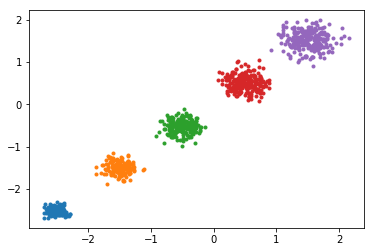

In [45]:
# load (or simulate) data
simulate = True
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    n_obs = len(iris_species)    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 5
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.2)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')
        
    iris_species = np.argmax(true_z, axis = 1)

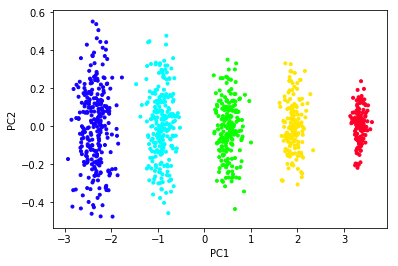

In [46]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


In [47]:
if simulate: 
    true_vb_params_dict = dict() 
    true_vb_params_dict['centroids'] = true_centroids.T
    true_vb_params_dict['v_stick_mean'] = np.ones(true_k - 1)
    true_vb_params_dict['v_stick_info'] = np.ones(true_k - 1)
    
    true_vb_params_dict['gamma'] = np.linalg.inv(true_covs)
    

# Set up model

### Get priors

In [48]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [49]:
print(prior_params_paragami)

OrderedDict:
	[alpha] = Array (1,) (lb=0.0, ub=inf)
	[prior_centroid_mean] = Array (1,) (lb=-inf, ub=inf)
	[prior_centroid_info] = Array (1,) (lb=0.0, ub=inf)
	[prior_gamma_df] = Array (1,) (lb=0.0, ub=inf)
	[prior_gamma_inv_scale] = PDMatrix 2x2 (diag_lb = 0.0)


In [50]:
# these are constrained parameters
print(prior_params_dict)

{'alpha': array([4.]), 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  ],
       [0.  , 0.62]])}


In [51]:
# these are free parameters
prior_params_paragami.flatten(prior_params_dict, free = True)

array([ 1.38629436,  0.        , -2.30258509,  2.07944154, -0.2390179 ,
        0.        , -0.2390179 ])

### the variational inference objective 

In [52]:
if simulate: 
    k_approx = true_k
else: 
    k_approx = 12

In [53]:
# Gauss-Hermite points
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [54]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [55]:
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

5152.72802138739

# Optimization 

### run k-means init

In [56]:
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init)

In [57]:
gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

468.58813951279836

In [58]:
init_vb_params_dict

OrderedDict([('centroids',
              array([[-1.50087621,  0.49543246, -0.50532678,  1.50724741, -2.50508667],
                     [-1.50063112,  0.51337657, -0.5230738 ,  1.52052836, -2.51076593]])),
             ('stick_propn_mean', array([1., 1., 1., 1.])),
             ('stick_propn_info', array([1., 1., 1., 1.])),
             ('gamma', array([[[ 58.44566871,   1.95829044],
                      [  1.95829044,  60.17146579]],
              
                     [[ 33.82889612,   3.14984972],
                      [  3.14984972,  32.10771147]],
              
                     [[ 45.62511797,  -1.68299981],
                      [ -1.68299981,  45.48603459]],
              
                     [[ 22.89720516,   0.38196518],
                      [  0.38196518,  23.90340566]],
              
                     [[113.78890079,   7.84034422],
                      [  7.84034422, 146.34438157]]]))])

In [60]:
def plot_results_from_vb_params_dict(vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


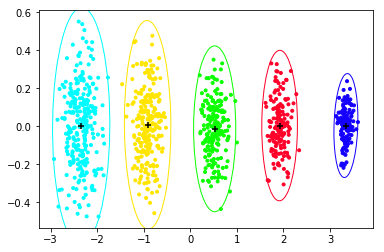

In [61]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(init_vb_params_dict, init_ez, fig)

## Run BFGS

### Set up losses

In [76]:
# Get loss as a function of the  vb_params_dict
get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
get_vb_params_loss.cache_args(features, None, prior_params_dict, gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_vb_free_params_loss = paragami.FlattenedFunction(
                                            original_fun=get_vb_params_loss,
                                            patterns=vb_params_paragami,
                                            free=True)


In [77]:
# get gradient 
get_vb_free_params_loss_grad = autograd.grad(get_vb_free_params_loss)
get_vb_free_params_loss_hess = autograd.hessian(get_vb_free_params_loss)

In [78]:
bfgs_vb_free_pars, bfgs_output = \
    gmm_lib.run_bfgs(get_vb_free_params_loss, init_vb_free_params, get_vb_free_params_loss_grad, 
                                 maxiter = 50)

         Current function value: -1086.360043
         Iterations: 50
         Function evaluations: 59
         Gradient evaluations: 59


In [79]:
bfgs_vb_free_pars = bfgs_output.x
bfgs_vb_params_dict = vb_params_paragami.fold(bfgs_vb_free_pars, free=True)
bfgs_vb_params_dict

OrderedDict([('centroids',
              array([[-1.50086421,  0.49540091, -0.50530475,  1.50715992, -2.50506299],
                     [-1.50062538,  0.51332245, -0.52306487,  1.52047219, -2.51073341]])),
             ('stick_propn_mean',
              array([-1.6373316 , -0.93254708, -0.66972459,  0.71330734])),
             ('stick_propn_info',
              array([106.96372667, 209.99055733, 120.23681664, 111.54062943])),
             ('gamma', array([[[49.76262767,  1.36143033],
                      [ 1.36143033, 50.96797768]],
              
                     [[31.9370675 ,  2.76269126],
                      [ 2.76269126, 30.44861193]],
              
                     [[41.39450336, -1.34903048],
                      [-1.34903048, 41.27896111]],
              
                     [[22.2573458 ,  0.33863533],
                      [ 0.33863533, 23.20206221]],
              
                     [[77.05169336,  3.13144264],
                      [ 3.13144264, 90.01536787

In [80]:
true_vb_params_dict

{'centroids': array([[-2.5, -1.5, -0.5,  0.5,  1.5],
        [-2.5, -1.5, -0.5,  0.5,  1.5]]),
 'gamma': array([[[125.        ,   0.        ],
         [  0.        , 125.        ]],
 
        [[ 62.5       ,   0.        ],
         [  0.        ,  62.5       ]],
 
        [[ 41.66666667,   0.        ],
         [  0.        ,  41.66666667]],
 
        [[ 31.25      ,   0.        ],
         [  0.        ,  31.25      ]],
 
        [[ 25.        ,   0.        ],
         [  0.        ,  25.        ]]]),
 'v_stick_info': array([1., 1., 1., 1.]),
 'v_stick_mean': array([1., 1., 1., 1.])}

In [83]:
bfgs_ez = gmm_lib.get_optimal_z_from_vb_params_dict(features, bfgs_vb_params_dict, gh_loc, gh_weights)

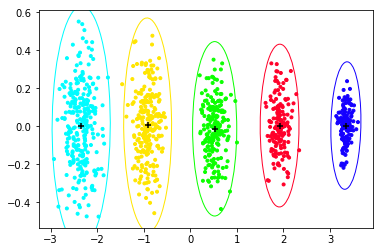

In [84]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(bfgs_vb_params_dict, bfgs_ez, fig)

### Get preconditioner and run Newton trust-region

In [85]:
trust_ncg_vb_free_pars, trust_ncg_output = \
    gmm_lib.precondition_and_optimize(get_vb_free_params_loss, bfgs_output.x)

         Current function value: -1086.403175
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 5
         Hessian evaluations: 5


In [86]:
vb_opt_dict = \
    vb_params_paragami.fold(trust_ncg_vb_free_pars, free = True)
    
vb_opt_dict

OrderedDict([('centroids',
              array([[-1.50085818,  0.49540719, -0.50532059,  1.50716549, -2.50506214],
                     [-1.50061354,  0.51332616, -0.52306738,  1.52046928, -2.51074501]])),
             ('stick_propn_mean',
              array([-1.63717949, -0.9326917 , -0.66969271,  0.71391169])),
             ('stick_propn_info',
              array([137.10116651, 170.5156826 , 135.31570184,  88.33034218])),
             ('gamma', array([[[49.76069064,  1.36213721],
                      [ 1.36213721, 50.96111236]],
              
                     [[31.9405651 ,  2.76419229],
                      [ 2.76419229, 30.45311553]],
              
                     [[41.38840857, -1.34608555],
                      [-1.34608555, 41.27716786]],
              
                     [[22.25753999,  0.33865975],
                      [ 0.33865975, 23.19995146]],
              
                     [[77.09694934,  3.12992503],
                      [ 3.12992503, 90.09336014

In [88]:
opt_ez = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

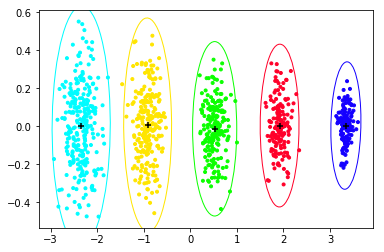

In [89]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(vb_opt_dict, opt_ez, fig)

# Checking out optimize full

In [101]:
random_vb_init_dict = vb_params_paragami.random()
random_vb_free_init = vb_params_paragami.flatten(random_vb_init_dict, free = True)

In [102]:
vb_opt = gmm_lib.optimize_full(features, vb_params_paragami, prior_params_dict,
                    random_vb_free_init, gh_loc, gh_weights,
                    bfgs_max_iter = 10, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: 280.895614
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15

 running preconditioned newton; iter =  0
         Current function value: -155.802297
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 45
         Hessian evaluations: 44
Iter 0: x_diff = 33.35193335182501, f_diff = 436.6979108550198, grad_l1 = 569.9704908738352

 running preconditioned newton; iter =  1
         Current function value: -323.030183
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 43
         Hessian evaluations: 42
Iter 1: x_diff = 29.492954315028953, f_diff = 167.22788564603627, grad_l1 = 423.3271906058744

 running preconditioned newton; iter =  2
         Current function value: -777.761618
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 44
         Hessian evaluations: 44
Iter 2: x_diff = 21.2

In [103]:
vb_opt_dict = \
    vb_params_paragami.fold(vb_opt, free = True)
    
vb_opt_dict

OrderedDict([('centroids',
              array([[ 1.50716503, -1.91784659,  0.49541454, -0.51103176, -0.50024147],
                     [ 1.520469  , -1.91995303,  0.51333328, -0.59078579, -0.51855618]])),
             ('stick_propn_mean',
              array([-1.00759755, -0.38948264,  0.1628139 , -4.99529766])),
             ('stick_propn_info',
              array([196.81225839, 177.20862518, 109.09446646,   1.77002158])),
             ('gamma', array([[[ 2.22573751e+01,  3.38545240e-01],
                      [ 3.38545240e-01,  2.31998906e+01]],
              
                     [[ 3.41774408e+01, -3.22410634e+01],
                      [-3.22410634e+01,  3.38963363e+01]],
              
                     [[ 3.19416233e+01,  2.76607720e+00],
                      [ 2.76607720e+00,  3.04541549e+01]],
              
                     [[ 8.92567953e+00, -5.92415891e-03],
                      [-5.92415891e-03,  8.71850560e+00]],
              
                     [[ 4.3248989

In [104]:
opt_ez = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

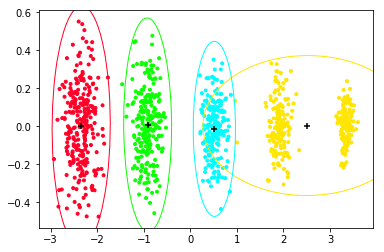

In [105]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(vb_opt_dict, opt_ez, fig)

In [106]:
# checking set optimal z

In [129]:
def get_kl_from_z_nat_param(y, vb_params_dict, prior_params_dict,
                    gh_loc, gh_weights, z_nat_param): 
    
    log_const = sp.misc.logsumexp(z_nat_param, axis=1)
    e_z = np.exp(z_nat_param - log_const[:, None])
    
    return gmm_lib.get_kl(y, vb_params_dict, prior_params_dict,
                    gh_loc, gh_weights,
                    e_z = e_z)

In [130]:
vb_params_dict = vb_params_paragami.random()

stick_propn_mean, stick_propn_info, centroids, gamma = gmm_lib._get_vb_params_from_dict(vb_params_dict)

z_nat_param = gmm_lib.get_z_nat_params(features, stick_propn_mean, stick_propn_info, centroids, gamma,
                        gh_loc, gh_weights)

get_kl_from_z_nat_param(features, vb_params_dict, prior_params_dict,
                    gh_loc, gh_weights, z_nat_param)

6484.924412126523

In [131]:
kl_grad = autograd.grad(get_kl_from_z_nat_param, 5)

In [133]:
z_nat_param

array([[ -0.86825951,  -1.9544001 ,  -3.34791321, -11.86574566,
         -6.19303203],
       [ -0.15163042,  -0.56914739,  -1.47624946,  -3.35290989,
         -3.70809686],
       [ -1.27697162,  -2.79313818,  -4.07512826, -13.92779614,
         -7.33040112],
       ...,
       [-19.27261343, -25.77812853, -12.58004495, -16.02950196,
        -24.88226707],
       [ -0.30712687,  -0.64693015,  -1.52435249,  -3.65429649,
         -4.07261684],
       [ -3.04509202,  -4.14875183,  -4.41857286, -15.74898527,
         -7.92694388]])

In [136]:
np.max(np.abs(kl_grad(features, vb_params_dict, prior_params_dict,
                    gh_loc, gh_weights, z_nat_param + \
                      np.random.randn(z_nat_param.shape[0], z_nat_param.shape[1]))))

0.7526387605791633